# 0.0 Set Up

## 1.0 Imports - !pip install <package_name> if necessary

In [2]:
import pandas as pd
import json

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics.pairwise import linear_kernel
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

import numpy as np
from tqdm.auto import tqdm


In [4]:
import os
os.environ["USE_TF"] = "0"
nltk.download('stopwords')
nltk.download('wordnet')  # For lemmatization

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marij\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marij\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 0.1 Helper Functions

In [6]:
def load_json_data(file_path):
    with open(file_path, "r") as file:
        contents = json.load(file)
    return contents


def create_tfidf_matrix(citing_dataset, nonciting_dataset, vectorizer=TfidfVectorizer()):
    """
    Creates TF-IDF matrix for the given citing and non-citing datasets based on the specified text column.

    Parameters:
    citing_dataset (json)): DataFrame containing citing patents.
    nonciting_dataset (json): DataFrame containing non-citing patents.
    vectorizer (TfidfVectorizer, optional): TfidfVectorizer object for vectorizing text data.
                                             Defaults to TfidfVectorizer().

    Returns:
    tuple: A tuple containing TF-IDF matrices for citing and non-citing patents respectively.
           (tfidf_matrix_citing, tfidf_matrix_nonciting)
    """
    all_text = [patent['text'] for patent in citing_dataset + nonciting_dataset]

    # Vectorizing descriptions
    print("Vectorizing descriptions...")
    tfidf_matrix = vectorizer.fit_transform(tqdm(all_text, desc="TF-IDF"))

    # Since we're interested in similarities between citing and cited patents,
    # we need to split the TF-IDF matrix back into two parts
    split_index = len(citing_dataset)
    tfidf_matrix_citing = tfidf_matrix[:split_index]
    tfidf_matrix_nonciting = tfidf_matrix[split_index:]

    # Size of vocabulary
    print("Size of vocabulary:", len(vectorizer.vocabulary_))

    return tfidf_matrix_citing, tfidf_matrix_nonciting



def get_mapping_dict(mapping_df):
    """
    Creates dictionary of citing ids to non-citing id based on given dataframe (which is based on providedjson)

    Parameters:
    mapping_df (DataFrame): DataFrame containing mapping between citing and cited patents
    Returns:
    dict: dictionary of unique citing patent ids to list of cited patent ids
    """
    mapping_dict = {}

    for _, row in mapping_df.iterrows():
        key = row[0]  # Value from column 0
        value = row[2]  # Value from column 2
        if key in mapping_dict:
            mapping_dict[key].append(value)
        else:
            mapping_dict[key] = [value]

    return mapping_dict

def create_corpus(corpus, text_type): #OVO NAM TREBA SASVIM SIGURNO
    """
    Extracts text data from a corpus based on the specified text type.

    Parameters:
    corpus (list): List of dictionaries representing patent documents.
    text_type (str): Type of text to extract ('title', 'abstract', 'claim1', 'claims', 'description', 'fulltext').

    Returns:
    list: List of dictionaries with 'id' and 'text' keys representing each document in the corpus.
    """

    app_ids = [doc['Application_Number'] + doc['Application_Category'] for doc in corpus]

    cnt = 0 # count the number of documents without text
    texts = []  # list of texts
    ids_to_remove = []  # list of ids of documents without text, to remove them from the corpus

    if text_type == 'title':
        for doc in corpus:
            try:
                texts.append(doc['Content']['title'])
            except: # if the document does not have a title
                ids_to_remove.append(doc['Application_Number']+doc['Application_Category'])
                cnt += 1
        print(f"Number of documents without title: {cnt}")

    elif text_type == 'abstract':
        for doc in corpus:
            try:
                texts.append(doc['Content']['pa01'])
            except: # if the document does not have an abstract
                ids_to_remove.append(doc['Application_Number']+doc['Application_Category'])
                cnt += 1
        print(f"Number of documents without abstract: {cnt}")

    elif text_type == 'claim1':
        for doc in corpus:
            try:
                texts.append(doc['Content']['c-en-0001'])
            except: # if the document does not have claim 1
                ids_to_remove.append(doc['Application_Number']+doc['Application_Category'])
                cnt += 1
        print(f"Number of documents without claim 1: {cnt}")

    elif text_type == 'claims':
        # all the values with the key starting with 'c-en-', each element in the final list is a list of claims
        for doc in corpus:
            doc_claims = []
            for key in doc['Content'].keys():
                if key.startswith('c-en-'):
                    doc_claims.append(doc['Content'][key])
            if len(doc_claims) == 0:    # if the document does not have any claims
                ids_to_remove.append(doc['Application_Number']+doc['Application_Category'])
                cnt += 1
            else:
                doc_text_string = ' '.join(doc_claims)
                texts.append(doc_text_string)
        print(f"Number of documents without claims: {cnt}")

    elif text_type == 'description':
        # all the values with the key starting with 'p'
        for doc in corpus:
            doc_text = []
            for key in doc['Content'].keys():
                if key.startswith('p'):
                    doc_text.append(doc['Content'][key])
            if len(doc_text) == 0:  # if the document does not have any description
                ids_to_remove.append(doc['Application_Number']+doc['Application_Category'])
                cnt += 1
            else:
                doc_text_string = ' '.join(doc_text)
                texts.append(doc_text_string)
        print(f"Number of documents without description: {cnt}")

    elif text_type == 'fulltext':
        for doc in corpus:
            doc_text = list(doc['Content'].values())
            doc_text_string = ' '.join(doc_text)
            texts.append(doc_text_string)
        if cnt > 0:
            print(f"Number of documents without any text: {cnt}")

    else:
        raise ValueError("Invalid text type")

    if len(ids_to_remove) > 0:
        print(f"Removing {len(ids_to_remove)} documents without required text")
        for id_ in ids_to_remove[::-1]:
            idx = app_ids.index(id_)
            del app_ids[idx]

    # Create a list of dictionaries with app_ids and texts
    corpus_data = [{'id': app_id, 'text': text} for app_id, text in zip(app_ids, texts)]

    return corpus_data


def get_true_and_predicted(citing_to_cited_dict, recommendations_dict):
    """
    Get the true and predicted labels for the metrics calculation.

    Parameters:
    citing_to_cited_dict : dict of str : list of str
        Mapping between citing patents and the list of their cited patents
    recommendations_dict : dict of str : list of str
        Mapping between citing patents and the sorted list of recommended patents

    Returns:
    list of list
        True relevant items for each recommendation list.
    list of list
        Predicted recommended items for each recommendation list.
    int
        Number of patents not in the citation mapping
    """
    # Initialize lists to store true labels and predicted labels
    true_labels = []
    predicted_labels = []
    not_in_citation_mapping = 0

    # Iterate over the items in both dictionaries
    for citing_id in recommendations_dict.keys():
        # Check if the citing_id is present in both dictionaries
        if citing_id in citing_to_cited_dict:
            # If yes, append the recommended items from both dictionaries to the respective lists
            true_labels.append(citing_to_cited_dict[citing_id])
            predicted_labels.append(recommendations_dict[citing_id])
        else:
            not_in_citation_mapping += 1

    return true_labels, predicted_labels, not_in_citation_mapping



def mean_recall_at_k(true_labels, predicted_labels, k=10):
    """
    Calculate the mean Recall@k for a list of recommendations.

    Parameters:
    true_labels : list of list
        True relevant items for each recommendation list.
    predicted_labels : list of list
        Predicted recommended items for each recommendation list.
    k : int
        Number of recommendations to consider.

    Returns:
    float
        Mean Recall@k value.
    """
    recalls_at_k = []

    for true, pred in zip(true_labels, predicted_labels):
        # Calculate Recall@k for each recommendation list
        true_set = set(true)
        k = min(k, len(pred))
        relevant_count = sum(1 for item in pred[:k] if item in true_set)
        recalls_at_k.append(relevant_count / len(true_set))

    # Calculate the mean Recall@k
    mean_recall = sum(recalls_at_k) / len(recalls_at_k)

    return mean_recall

def mean_inv_ranking(true_labels, predicted_labels):
    """
    Calculate the mean of lists of the mean inverse rank of true relevant items
    in the lists of sorted recommended items.

    Parameters:
    true_labels : list of list
        True relevant items for each recommendation list.
    predicted_labels : list of list
        Predicted recommended items for each recommendation list.

    Returns:
    float
        Mean of lists of the mean inverse rank of true relevant items.
    """
    mean_ranks = []

    for true, pred in zip(true_labels, predicted_labels):
        # Calculate the inverse rank of true relevant items
        # in the recommendation list
        ranks = []
        for item in true:
            try:
                rank = 1 / (pred.index(item) + 1)
            except ValueError:
                rank = 0  # If item not found, assign 0
            ranks.append(rank)

        # Calculate the mean inverse rank of true relevant items
        # in the recommendation list
        mean_rank = sum(ranks) / len(ranks)
        mean_ranks.append(mean_rank)

    # Calculate the mean of the mean inverse ranks across all recommendation lists
    mean_of_mean_ranks = sum(mean_ranks) / len(mean_ranks)

    return mean_of_mean_ranks


def mean_ranking(true_labels, predicted_labels):
    """
    Calculate the mean of lists of the mean rank of true relevant items
    in the lists of sorted recommended items.

    Parameters:
    true_labels : list of list
        True relevant items for each recommendation list.
    predicted_labels : list of list
        Predicted recommended items for each recommendation list.

    Returns:
    float
        Mean of lists of the mean rank of true relevant items.
    """
    mean_ranks = []

    for true, pred in zip(true_labels, predicted_labels):
        # Calculate the rank of true relevant items
        # in the recommendation list
        ranks = []
        for item in true:
            try:
                rank = pred.index(item) + 1
            except ValueError:
                rank = len(pred)  # If item not found, assign the length of the list
            ranks.append(rank)

        # Calculate the mean rank of true relevant items
        # in the recommendation list
        mean_rank = sum(ranks) / len(ranks)
        mean_ranks.append(mean_rank)

    # Calculate the mean of the mean ranks across all recommendation lists
    mean_of_mean_ranks = sum(mean_ranks) / len(mean_ranks)

    return mean_of_mean_ranks



def mean_average_precision(true_labels, predicted_labels, k=10):
    """
    Calculate the mean Average Precision for a list of recommendations.

    Parameters:
    true_labels : list of list
        True relevant items for each recommendation list.
    predicted_labels : list of list
        Predicted recommended items for each recommendation list.
    k : int
        Number of recommendations to consider.

    Returns:
    float
        Mean Average Precision value.
    """
    average_precisions = []

    for true, pred in zip(true_labels, predicted_labels):
        # Calculate Average Precision for each recommendation list
        true_set = set(true)
        precision_at_k = []
        relevant_count = 0
        for i, item in enumerate(pred[:k]):
            if item in true_set:
                relevant_count += 1
                precision_at_k.append(relevant_count / (i + 1))
        average_precision = sum(precision_at_k) / len(true_set)
        average_precisions.append(average_precision)

    # Calculate the mean Average Precision
    mean_average_precision = sum(average_precisions) / len(average_precisions)

    return mean_average_precision

def top_k_ranks(citing, cited, cosine_similarities, k=10):
    # Create a dictionary to store the top k ranks for each citing patent
    top_k_ranks = {}
    for i, content_id in enumerate(citing):
        top_k_ranks[content_id['id']] = [cited[j]['id'] for j in np.argsort(cosine_similarities[i])[::-1][:k]]
    return top_k_ranks


# 1.0 Load Datasets

In [8]:
json_citing_train = load_json_data("./datasets/Content_JSONs/Citing_2020_Cleaned_Content_12k/Citing_Train_Test/citing_TRAIN.json")
json_citing_test = load_json_data("./datasets/Content_JSONs/Citing_2020_Cleaned_Content_12k/Citing_Train_Test/citing_TEST.json")

json_nonciting = load_json_data("./datasets/Content_JSONs/Cited_2020_Uncited_2010-2019_Cleaned_Content_22k/CLEANED_CONTENT_DATASET_cited_patents_by_2020_uncited_2010-2019.json")
json_citing_to_cited = load_json_data("./datasets/Citation_JSONs/Citation_Train.json") # Citing ids are unique

In [10]:
citing_dataset_df = pd.DataFrame(json_citing_train)

nonciting_dataset_df = pd.DataFrame(json_nonciting)
mapping_dataset_df = pd.DataFrame(json_citing_to_cited)

In [12]:
citing_dataset_df

,Application_Number,Application_Date,Application_Category,Content
0,3650293,2020-05-13,A1,{'title': 'DEVICE FOR CONTROLLING THE BRAKING ...
1,3694265,2020-08-12,A1,{'title': 'TIME DIVISION MULTIPLEXING OF SYNCH...
2,3623522,2020-03-18,A1,{'title': 'LAUNDRY MACHINE AND CONTROL METHOD ...
3,3611147,2020-02-19,A1,{'title': 'CHEMICAL AND TOPOLOGICAL SURFACE MO...
4,3640454,2020-04-22,A1,"{'title': 'FUEL METERING SYSTEM', 'pa01': 'The..."
...,...,...,...,...
6826,3741587,2020-11-25,A1,{'title': 'AUTO-LOCATION USING TIRE MOUNTED SY...
6827,3693248,2020-08-12,A1,{'title': 'HOLE COVER AND STEERING SYSTEM INCL...
6828,3628962,2020-04-01,A1,{'title': 'SYSTEM AND METHOD FOR MEASURING CLE...
6829,3620899,2020-03-11,A1,{'title': 'TOUCH SCREEN AND DISPLAY APPARATUS'...


In [14]:
nonciting_dataset_df

,Application_Number,Application_Date,Application_Category,Content
0,2019772,2013-08-28,B1,"{'title': 'VEHICLE WITH LOCKABLE TILT SYSTEM',..."
1,2136094,2013-05-22,B1,"{'title': 'UNIVERSAL JOINT', 'c-en-0001': 'A u..."
2,2340701,2011-07-06,A2,"{'title': 'Apparatus, method and computer prog..."
3,2338661,2011-06-29,A1,{'title': 'Method and apparatus for forming a ...
4,2339144,2011-06-29,A2,{'title': 'Heat exchanger mounting assembly in...
...,...,...,...,...
16832,1995910,2012-07-11,B1,"{'title': 'Synchronization of a split audio, v..."
16833,1997557,2012-02-08,B1,{'title': 'Fluid handling unit and fluid handl...
16834,1992846,2012-04-04,B1,"{'title': 'Oil pump system for vehicle', 'c-en..."
16835,1981195,2012-01-11,B1,{'title': 'Apparatus for construction of quasi...


In [15]:
mapping_dataset_df #this means patents '0' are rejected because their clames '1' have been mentioned in patents '2' in paragraphs '3' and the decision is '3'

,0,1,2,3,4
0,3712070A1,[c-en-0004],3354576A1,"[p0024, p0027, c-en-0012, c-en-0013]",A
1,3675165A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",3336831A2,"[p0045, p0046, p0047, p0048, p0049, p0050, p00...",A
2,3599626A1,"[c-en-0002, c-en-0003, c-en-0004, c-en-0005, c...",2453448A1,"[p0029, p0030]",A
3,3705201A1,"[c-en-0001, c-en-0002, c-en-0004, c-en-0006, c...",2468433A2,"[p0011, p0012, p0013, p0014, p0015, p0016, p00...",X
4,3628210A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",3369366A1,[pa01],A
...,...,...,...,...,...
8589,3623977A1,"[c-en-0008, c-en-0009, c-en-0010, c-en-0011, c...",2518981A1,"[p0021, p0022, p0023, p0024, p0025, p0026, p00...",A
8590,3721843A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",3213727A1,"[p0015, p0016, p0017, p0018, p0019, p0020, p00...",X
8591,3708263A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",3217171A1,"[pa01, p0010, p0014, p0003, p0009, p0016]",A
8592,3588557A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",2988328A1,"[p0047, p0012]",A


In [15]:
mapping_dict = get_mapping_dict(mapping_dataset_df)
#mapping_dict

In [14]:
#import ast
#nonciting_dataset_df['all_content'] = nonciting_dataset_df['Content'].apply(ast.literal_eval)

## 1.1 Take a look at the content

In [19]:
#nonciting_dataset_df.loc[0].Content #dictionary basicaly

## 1.2 Create a column with the Title

Note for lateR: Try all text content by uncommenting the below

In [19]:
#import ast
#nonciting_dataset_df['all_content'] = nonciting_dataset_df['Content'].apply(ast.literal_eval)

In [21]:
def extract_title(dictionary):
    return dictionary.get('title', None)  # Return None if 'title' key is not present

nonciting_dataset_df['Title'] = nonciting_dataset_df['Content'].apply(extract_title)
citing_dataset_df['Title'] = citing_dataset_df['Content'].apply(extract_title)

nonciting_dataset_df

,Application_Number,Application_Date,Application_Category,Content,Title
0,2019772,2013-08-28,B1,"{'title': 'VEHICLE WITH LOCKABLE TILT SYSTEM',...",VEHICLE WITH LOCKABLE TILT SYSTEM
1,2136094,2013-05-22,B1,"{'title': 'UNIVERSAL JOINT', 'c-en-0001': 'A u...",UNIVERSAL JOINT
2,2340701,2011-07-06,A2,"{'title': 'Apparatus, method and computer prog...","Apparatus, method and computer program product..."
3,2338661,2011-06-29,A1,{'title': 'Method and apparatus for forming a ...,Method and apparatus for forming a rubber article
4,2339144,2011-06-29,A2,{'title': 'Heat exchanger mounting assembly in...,Heat exchanger mounting assembly in a gas turbine
...,...,...,...,...,...
16832,1995910,2012-07-11,B1,"{'title': 'Synchronization of a split audio, v...","Synchronization of a split audio, video, or ot..."
16833,1997557,2012-02-08,B1,{'title': 'Fluid handling unit and fluid handl...,Fluid handling unit and fluid handling apparat...
16834,1992846,2012-04-04,B1,"{'title': 'Oil pump system for vehicle', 'c-en...",Oil pump system for vehicle
16835,1981195,2012-01-11,B1,{'title': 'Apparatus for construction of quasi...,Apparatus for construction of quasi orthogonal...


## 1.3 Number of CITED patents per citing patent

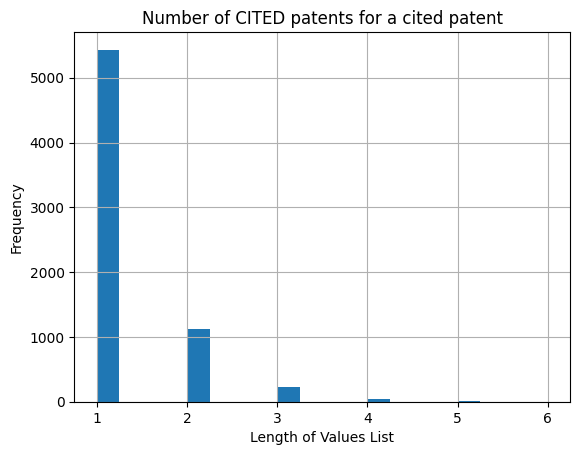

In [24]:
list_lengths = [len(values) for values in mapping_dict.values()]

plt.hist(list_lengths, bins=20)
plt.xlabel('Length of Values List')
plt.ylabel('Frequency')
plt.title('Number of CITED patents for a cited patent')
plt.grid(True)
plt.show()


# 2 Solution

## 2.1 Doc2Vec on claims for citing patents and description on cited patents

In [18]:
claims_citing_train = create_corpus(json_citing_train , 'claims')
claims_citing_test = create_corpus(json_citing_test , 'claims')

descriprion_nonciting = create_corpus(json_nonciting, 'description')
#claims_citing_train[:2]

Number of documents without claims: 0
Number of documents without claims: 0
Number of documents without description: 0


In [25]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess

all_docs_d2v_cd = claims_citing_train + descriprion_nonciting

tagged_docs_d2v_cd = [
    TaggedDocument(words=simple_preprocess(doc['text']), tags=[doc['id']])
    for doc in all_docs_d2v_cd
] #gensim.utils.simple_preprocess() uzima samo slova min duzine 2 max duzine 15 

In [81]:
model_d2v_cd = Doc2Vec(vector_size=300, window=5, min_count=2, workers=4, epochs = 30)

model_d2v_cd.build_vocab(tagged_docs_d2v_cd)

model_d2v_cd.train(tagged_docs_d2v_cd, total_examples=model_d2v_cd.corpus_count, epochs=model_d2v_cd.epochs)

In [83]:
vectors_by_id_d2v_cd = {doc['id']: model_d2v_cd.dv[doc['id']] for doc in claims_citing_train}
vectors_by_id_d2v_cd1 = {doc['id']: model_d2v_cd.dv[doc['id']] for doc in descriprion_nonciting}

In [85]:
vectors_by_id_list_d2v_cd = [vec.tolist() for vec in vectors_by_id_d2v_cd.values()]
vectors_by_id_list_d2v_cd1 = [vec.tolist() for vec in vectors_by_id_d2v_cd1.values()]

In [87]:
cosine_similarities_d2v_cd = linear_kernel(vectors_by_id_list_d2v_cd, vectors_by_id_list_d2v_cd1)
cosine_similarities_d2v_cd

array([[ 39.49397811,   0.98374973, -11.93806485, ..., 152.03763204,
         77.40695888,  73.27581816],
       [ 33.66263193,  71.12007491,   3.89147258, ..., 102.04341433,
        263.73567392,  37.30822347],
       [-10.28393857, 101.36186157,  37.40638435, ..., 140.0906916 ,
        142.27349774, 102.37799452],
       ...,
       [ 40.36568969,  75.67053   , 125.45306009, ...,  64.03504559,
        151.23393979,  95.56943164],
       [ 56.59590675,  40.90261777,  71.9046428 , ...,  46.89412168,
         26.61155278,  93.84565203],
       [ 50.12080406,  59.4145261 ,  70.92224427, ...,  40.9450836 ,
         78.77828106,  57.54824045]])

In [89]:
k = 100
top_k_rank_d2v_cd = top_k_ranks(claims_citing_train, descriprion_nonciting, cosine_similarities_d2v_cd, k=k)

# Calculate the metrics
true_labels, predicted_labels, not_in_citation_mapping = \
    get_true_and_predicted(mapping_dict, top_k_rank)
mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)
recall_at_10_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10_claim1_tfidf, 4))
print("Recall at 20:", round(recall_at_20_claim1_tfidf, 4))
print("Recall at 50:", round(recall_at_50_claim1_tfidf, 4))
print("Recall at 100:", round(recall_at_100_claim1_tfidf, 4))


print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

Recall at 10: 0.4727
Recall at 20: 0.5632
Recall at 50: 0.6828
Recall at 100: 0.7656
Mean ranking: 36.1989
Mean average precision: 0.283
Number of patents measured: 6831
Number of patents not in the citation: 0


In [91]:
claim1_citing_train = create_corpus(json_citing_train , 'claim1')
claim1_citing_test = create_corpus(json_citing_test , 'claim1')

claims_nonciting = create_corpus(json_nonciting, 'claims')
#claims_citing_train[:2]
all_docs = claim1_citing_train + claims_nonciting
tagged_docs = [
    TaggedDocument(words=simple_preprocess(doc['text']), tags=[doc['id']])
    for doc in all_docs
]
model = Doc2Vec(vector_size=300, window=5, min_count=2, workers=4, epochs = 30)

model.build_vocab(tagged_docs)

model.train(tagged_docs, total_examples=model.corpus_count, epochs=model.epochs)
vectors_by_id = {doc['id']: model.dv[doc['id']] for doc in claim1_citing_train}

vectors_by_id1 = {doc['id']: model.dv[doc['id']] for doc in claims_nonciting}
vectors_by_id_list = [vec.tolist() for vec in vectors_by_id.values()]
vectors_by_id_list1 = [vec.tolist() for vec in vectors_by_id1.values()]

cosine_similarities = linear_kernel(vectors_by_id_list, vectors_by_id_list1)
cosine_similarities

k = 100
top_k_rank = top_k_ranks(claim1_citing_train, claims_nonciting, cosine_similarities, k=k)

# Calculate the metrics
true_labels, predicted_labels, not_in_citation_mapping = \
    get_true_and_predicted(mapping_dict, top_k_rank)
mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)
recall_at_10_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10_claim1_tfidf, 4))
print("Recall at 20:", round(recall_at_20_claim1_tfidf, 4))
print("Recall at 50:", round(recall_at_50_claim1_tfidf, 4))
print("Recall at 100:", round(recall_at_100_claim1_tfidf, 4))


print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

Number of documents without claim 1: 0
Number of documents without claim 1: 0
Number of documents without claims: 3
Removing 3 documents without required text
Recall at 10: 0.2439
Recall at 20: 0.3065
Recall at 50: 0.4152
Recall at 100: 0.4979
Mean ranking: 61.7052
Mean average precision: 0.1325
Number of patents measured: 6831
Number of patents not in the citation: 0


In [92]:
claim1_citing_train = create_corpus(json_citing_train , 'claim1')
claim1_citing_test = create_corpus(json_citing_test , 'claim1')

claim1_nonciting = create_corpus(json_nonciting, 'claim1')
#claims_citing_train[:2]
all_docs = claim1_citing_train + claim1_nonciting
tagged_docs = [
    TaggedDocument(words=simple_preprocess(doc['text']), tags=[doc['id']])
    for doc in all_docs
]
model = Doc2Vec(vector_size=300, window=5, min_count=2, workers=4, epochs = 30)

model.build_vocab(tagged_docs)

model.train(tagged_docs, total_examples=model.corpus_count, epochs=model.epochs)
vectors_by_id = {doc['id']: model.dv[doc['id']] for doc in claim1_citing_train}

vectors_by_id1 = {doc['id']: model.dv[doc['id']] for doc in claim1_nonciting}
vectors_by_id_list = [vec.tolist() for vec in vectors_by_id.values()]
vectors_by_id_list1 = [vec.tolist() for vec in vectors_by_id1.values()]

cosine_similarities = linear_kernel(vectors_by_id_list, vectors_by_id_list1)
cosine_similarities

k = 100
top_k_rank = top_k_ranks(claim1_citing_train, claim1_nonciting, cosine_similarities, k=k)

# Calculate the metrics
true_labels, predicted_labels, not_in_citation_mapping = \
    get_true_and_predicted(mapping_dict, top_k_rank)
mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)
recall_at_10_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10_claim1_tfidf, 4))
print("Recall at 20:", round(recall_at_20_claim1_tfidf, 4))
print("Recall at 50:", round(recall_at_50_claim1_tfidf, 4))
print("Recall at 100:", round(recall_at_100_claim1_tfidf, 4))


print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

Number of documents without claim 1: 0
Number of documents without claim 1: 0
Number of documents without claim 1: 3
Removing 3 documents without required text
Recall at 10: 0.0849
Recall at 20: 0.1206
Recall at 50: 0.1875
Recall at 100: 0.2514
Mean ranking: 82.723
Mean average precision: 0.0419
Number of patents measured: 6831
Number of patents not in the citation: 0


In [69]:
from sentence_transformers import SentenceTransformer
import torch
from transformers import AutoModel
import transformers
#VECTOR LENGTH IS 384

#this next part is because we had some huge problems with importing of transformers and this solves it
if not hasattr(transformers.modeling_utils, 'init_empty_weights'):
    from contextlib import contextmanager
    @contextmanager
    def init_empty_weights():
        yield
    transformers.modeling_utils.init_empty_weights = init_empty_weights

if not hasattr(transformers.modeling_utils, 'find_tied_parameters'):
    def find_tied_parameters(*args, **kwargs):
        return {}
    transformers.modeling_utils.find_tied_parameters = find_tied_parameters


try:
    model = SentenceTransformer(
        'all-MiniLM-L6-v2',
        device='cuda' if torch.cuda.is_available() else 'cpu',
        model_kwargs={
            'low_cpu_mem_usage': True,
            'tie_word_embeddings': False 
        }
    )
except Exception as e:
    print(f"First load attempt failed: {e}")
    model = SentenceTransformer(
        'all-MiniLM-L6-v2',
        device='cpu'
    )


#from here is our actual code
claims_citing_train = create_corpus(json_citing_train, 'claims')
claims_citing_test = create_corpus(json_citing_test, 'claims')
description_nonciting = create_corpus(json_nonciting, 'description')

texts_citing = [doc['text'] for doc in claims_citing_train]
texts_nonciting = [doc['text'] for doc in description_nonciting]

embeddings_citing = model.encode(texts_citing, convert_to_tensor=True)
embeddings_nonciting = model.encode(texts_nonciting, convert_to_tensor=True)

cosine_similarities = linear_kernel(embeddings_citing.tolist(), embeddings_nonciting.tolist())

k = 100
top_k_rank = top_k_ranks(claims_citing_train, descriprion_nonciting, cosine_similarities, k=k)

# Calculate metrics
true_labels, predicted_labels, not_in_citation_mapping = get_true_and_predicted(mapping_dict, top_k_rank)
mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)
recall_at_10 = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20 = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50 = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100 = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10, 4))
print("Recall at 20:", round(recall_at_20, 4))
print("Recall at 50:", round(recall_at_50, 4))
print("Recall at 100:", round(recall_at_100, 4))
print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in citation:", not_in_citation_mapping)

First load attempt failed: [Errno 2] No such file or directory: 'sentence-transformers/all-MiniLM-L6-v2\\sentence_xlnet_config.json'
Number of documents without claims: 0
Number of documents without claims: 0
Number of documents without description: 0
Recall at 10: 0.5214
Recall at 20: 0.6158
Recall at 50: 0.7378
Recall at 100: 0.8104
Mean ranking: 31.2318
Mean average precision: 0.3208
Number of patents measured: 6831
Number of patents not in citation: 0


In [73]:
#from here is our actual code
claim1_citing_train = create_corpus(json_citing_train, 'claim1')
claim1_citing_test = create_corpus(json_citing_test, 'claim1')
clames_nonciting = create_corpus(json_nonciting, 'claims')

texts_citing = [doc['text'] for doc in claim1_citing_train]
texts_nonciting = [doc['text'] for doc in clames_nonciting]

embeddings_citing = model.encode(texts_citing, convert_to_tensor=True)
embeddings_nonciting = model.encode(texts_nonciting, convert_to_tensor=True)

cosine_similarities = linear_kernel(embeddings_citing.tolist(), embeddings_nonciting.tolist())

k = 100
top_k_rank = top_k_ranks(claim1_citing_train, clames_nonciting, cosine_similarities, k=k)

# Calculate metrics
true_labels, predicted_labels, not_in_citation_mapping = get_true_and_predicted(mapping_dict, top_k_rank)
mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)
recall_at_10 = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20 = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50 = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100 = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10, 4))
print("Recall at 20:", round(recall_at_20, 4))
print("Recall at 50:", round(recall_at_50, 4))
print("Recall at 100:", round(recall_at_100, 4))
print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in citation:", not_in_citation_mapping)

Number of documents without claim 1: 0
Number of documents without claim 1: 0
Number of documents without claims: 3
Removing 3 documents without required text
Recall at 10: 0.493
Recall at 20: 0.5847
Recall at 50: 0.6995
Recall at 100: 0.7747
Mean ranking: 34.5613
Mean average precision: 0.3053
Number of patents measured: 6831
Number of patents not in citation: 0


In [75]:
#from here is our actual code
claim1_citing_train = create_corpus(json_citing_train, 'claim1')
claim1_citing_test = create_corpus(json_citing_test, 'claim1')
clame1_nonciting = create_corpus(json_nonciting, 'claim1')

texts_citing = [doc['text'] for doc in claim1_citing_train]
texts_nonciting = [doc['text'] for doc in clame1_nonciting]

embeddings_citing = model.encode(texts_citing, convert_to_tensor=True)
embeddings_nonciting = model.encode(texts_nonciting, convert_to_tensor=True)

cosine_similarities = linear_kernel(embeddings_citing.tolist(), embeddings_nonciting.tolist())

k = 100
top_k_rank = top_k_ranks(claim1_citing_train, clame1_nonciting, cosine_similarities, k=k)

# Calculate metrics
true_labels, predicted_labels, not_in_citation_mapping = get_true_and_predicted(mapping_dict, top_k_rank)
mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)
recall_at_10 = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20 = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50 = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100 = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10, 4))
print("Recall at 20:", round(recall_at_20, 4))
print("Recall at 50:", round(recall_at_50, 4))
print("Recall at 100:", round(recall_at_100, 4))
print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in citation:", not_in_citation_mapping)

Number of documents without claim 1: 0
Number of documents without claim 1: 0
Number of documents without claim 1: 3
Removing 3 documents without required text
Recall at 10: 0.4763
Recall at 20: 0.5609
Recall at 50: 0.6795
Recall at 100: 0.7568
Mean ranking: 36.5708
Mean average precision: 0.2922
Number of patents measured: 6831
Number of patents not in citation: 0


# 4.0 Get Test Predictions for CodaBench

In [95]:
claims_citing_test = create_corpus(json_citing_test, 'claims')
description_nonciting = create_corpus(json_nonciting, 'description')

Number of documents without claims: 0
Number of documents without description: 0


In [103]:
if not hasattr(transformers.modeling_utils, 'init_empty_weights'):
    from contextlib import contextmanager
    @contextmanager
    def init_empty_weights():
        yield
    transformers.modeling_utils.init_empty_weights = init_empty_weights

if not hasattr(transformers.modeling_utils, 'find_tied_parameters'):
    def find_tied_parameters(*args, **kwargs):
        return {}
    transformers.modeling_utils.find_tied_parameters = find_tied_parameters


try:
    model = SentenceTransformer(
        'all-MiniLM-L6-v2',
        device='cuda' if torch.cuda.is_available() else 'cpu',
        model_kwargs={
            'low_cpu_mem_usage': True,
            'tie_word_embeddings': False 
        }
    )
except Exception as e:
    print(f"First load attempt failed: {e}")
    model = SentenceTransformer(
        'all-MiniLM-L6-v2',
        device='cpu'
    )

First load attempt failed: [Errno 2] No such file or directory: 'sentence-transformers/all-MiniLM-L6-v2\\sentence_xlnet_config.json'


In [105]:
texts_citing = [doc['text'] for doc in claims_citing_test]
texts_nonciting = [doc['text'] for doc in description_nonciting]
embeddings_citing = model.encode(texts_citing, convert_to_tensor=True)
embeddings_nonciting = model.encode(texts_nonciting, convert_to_tensor=True)

cosine_similarities = linear_kernel(embeddings_citing.tolist(), embeddings_nonciting.tolist())

k = 100
top_k_rank = top_k_ranks(claims_citing_test, description_nonciting, cosine_similarities, k=k)

In [58]:
# Create BM25 similarity scores
#bm25_scores = create_bm25_matrix(title_citing_test, title_nonciting)
#top_k_rank = top_k_ranks(title_citing_test, title_nonciting, bm25_scores, k=k)

#print(f"Shape of BM25 scores matrix: {bm25_scores.shape}")

Vectorizing descriptions...
Computing BM25 scores...
Shape of BM25 scores matrix: (1000, 16837)


In [115]:
with open('prediction1.json', 'w') as f:
    json.dump(top_k_rank, f)